# Fake News Detection

<img src="images/fake_news.jpg" alt="Drawing" style="width: 1000px;height:300px;float: left;"/>

## Summary
This prokect uses text data from over 114,000 articles to develop a text classification model that can accuractely identify fake news articles. The data consists of both fake and real news articles from numerous online publiocations such as Reuters and BuzzFeed. The model is being developed for a technology comapny that is looking to reduce misinformation on their platform. Doing so will imporve their customer experience, and reduce the possibility of any legal issues. The data was loaded and cleaned using the pandas library and split into training, testing, and validation datasets using sklearn. The training and validation sets were further split into smaller training and validation sets for faster processing on initial modeling iterations. The model uses classifiers from the sklearn library. After establishing a baseline model, multiple iterations are developed with different preprocessing and feature engineering techniques form the nltk library.

## Business Problem
A social media company is looking to reduce the sharing of misinformation on its platform. Having widespread misinformation on the platform may dicourage new users and may cause the platform to lose existing customers. Additionaly, reducing fake articles on the platform could remove any potential legal issues.

## Data Understanding
This project uses multiple datasets of over 102,000 articles from online publications such as Reuters and BuzzFeed. The data is balanced, having about 52% of the data being fake news articles.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
import shap
from sklearn.metrics import confusion_matrix
import seaborn as sn
#import gensim

ImportError: cannot import name 'int' from 'numpy' (C:\Users\bento\anaconda3\envs\learn-env\lib\site-packages\numpy\__init__.py)

In [4]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [1]:
# load datasets
fake_or_real_df_1 = pd.read_csv('Data/fake_or_real_news.csv')
fake_df_2 = pd.read_csv('Data/Fake.csv')
true_df_2 = pd.read_csv('Data/True.csv')

NameError: name 'pd' is not defined

In [3]:
# preview first df
fake_or_real_df_1.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [4]:
# preview second df
fake_df_2.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
# preview third df
true_df_2.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [7]:
# select desired columns from each dataframe and set label
fake_or_real_df_1 = fake_or_real_df_1[['text', 'label']]

fake_df_2 = fake_df_2[['text']]
true_df_2 = true_df_2[['text']]

fake_df_2['label'] = 'FAKE'
true_df_2['label'] = 'REAL'

In [8]:
# combine all three datasets
fake_or_real_df = pd.concat([fake_or_real_df_1, fake_df_2, true_df_2])

In [10]:
fake_or_real_df.duplicated().any()

True

In [11]:
fake_or_real_df.isna().any()

text     False
label    False
dtype: bool

In [12]:
# remove duplicate data points
fake_or_real_df.drop_duplicates(inplace=True)

In [15]:
# preview final full dataset
fake_or_real_df

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL
...,...,...
21412,BRUSSELS (Reuters) - NATO allies on Tuesday we...,REAL
21413,"LONDON (Reuters) - LexisNexis, a provider of l...",REAL
21414,MINSK (Reuters) - In the shadow of disused Sov...,REAL
21415,MOSCOW (Reuters) - Vatican Secretary of State ...,REAL


In [16]:
# check class balance
fake_or_real_df.label.value_counts(normalize=True)

REAL    0.540889
FAKE    0.459111
Name: label, dtype: float64

Real Articles:  24181
Fake Articles:  20525


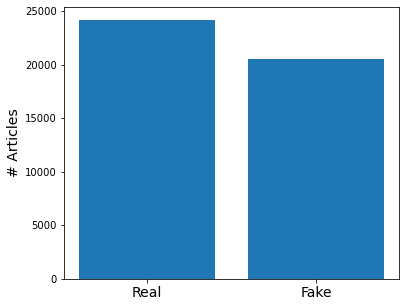

In [17]:
# plot the class distribution
counts = fake_or_real_df.label.value_counts()
fig, ax = plt.subplots(figsize=(6, 5))
plt.bar(['Real', 'Fake'], counts);
plt.ylabel('# Articles', fontsize=14);
plt.xticks(fontsize=14)
print("Real Articles: ", counts[0])
print("Fake Articles: ", counts[1])

## Data Preparation and Exploration
The data is split into a train, test, and validation set. The case of the text data is standardized and tokenized. The frequency distributions of the data are examined. 

### Data Splitting

In [75]:
# define featrues and target variables
X = fake_or_real_df['text']
y = fake_or_real_df['label']

In [76]:
# intial split of data into traiing and test sets with 15% test size
X_train_1, X_test, y_train_1, y_test = train_test_split(X, y, test_size=.15, 
                                                        random_state=42)

In [77]:
# second split of data into training and validation sets with 15% val size
X_train, X_val, y_train, y_val = train_test_split(X_train_1, y_train_1, 
                                                  test_size=0.15,
                                                  random_state=42)

In [78]:
print("Training Size: ", len(X_train))
print("Test Size: ", len(X_test))
print("Validation Size: ", len(X_val))

Training Size:  32300
Test Size:  6706
Validation Size:  5700


### Exploratory Data Analysis

In [79]:
#reconstruct X_train to include labels for eda
eda_X_train = pd.DataFrame(X_train)
eda_y_train = pd.DataFrame(y_train)

eda_X_train.reset_index(inplace=True, drop=True)
eda_y_train.reset_index(inplace=True, drop=True)

eda_X_train['label'] = eda_y_train

In [81]:
# Transform  data to lowercase and add tokenized data to df
eda_X_train['text'] = eda_X_train['text'].str.lower()

# Tokenize data
token_pattern = r"(?u)\b\w\w+\b"

tokenizer = RegexpTokenizer(token_pattern)

# create new column for tokenized data
eda_X_train['tokenized'] = eda_X_train['text'].apply(tokenizer.tokenize)

In [83]:
eda_X_train.head()

,text,label,tokenized
0,"during his bizarre rally in youngstown, ohio...",FAKE,"[during, his, bizarre, rally, in, youngstown, ..."
1,washington (reuters) - president donald trump ...,REAL,"[washington, reuters, president, donald, trump..."
2,the woman whose criminal investigation has bee...,FAKE,"[the, woman, whose, criminal, investigation, h..."
3,tune in to the alternate current radio network...,FAKE,"[tune, in, to, the, alternate, current, radio,..."
4,copenhagen (reuters) - danish police have char...,REAL,"[copenhagen, reuters, danish, police, have, ch..."


In [187]:
# define function for plotting top 10 words of freq dist for real and fake data
def top_10_comparison(column, title):

    #define freq distributions for fake and real datasets
    real_freq_dist = FreqDist(eda_X_train.loc[eda_X_train.label == 'REAL',
                                              column].explode())
    fake_freq_dist = FreqDist(eda_X_train.loc[eda_X_train.label == 'FAKE',
                                              column].explode())
    
    # Extract data for plotting
    real_top_10 = list(zip(*real_freq_dist.most_common(10)))
    real_tokens = real_top_10[0]
    real_counts = real_top_10[1]
    
    fake_top_10 = list(zip(*fake_freq_dist.most_common(10)))
    fake_tokens = fake_top_10[0]
    fake_counts = fake_top_10[1]
    

    # Set up plot and plot data
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].bar(real_tokens, real_counts)
    ax[1].bar(fake_tokens, fake_counts)
    
    fig.suptitle(title)
    # Customize plot appearance
    ax[0].set_title("Real Text")
    ax[0].set_ylabel("Count")
    ax[0].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[0].tick_params(axis="x", rotation=45)
    
    ax[1].set_title("Fake Text")
    ax[1].set_ylabel("Count")
    ax[1].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[1].tick_params(axis="x", rotation=45)

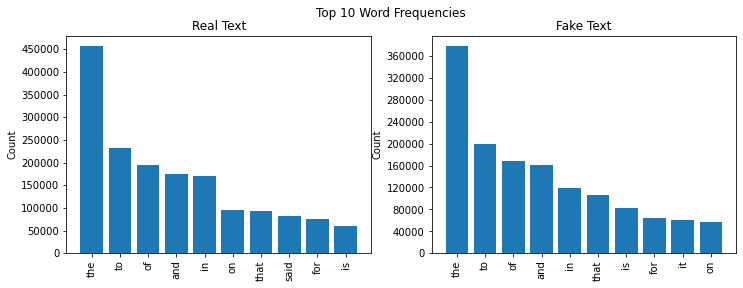

In [114]:
top_10_comparison('tokenized', "Top 10 Word Frequencies")

## Baseline Modeling
A baseline naive bayes tfidf model is developed for comparison to future iterations.

In [88]:
# Instantiate a vectorizer with max_features=10
baseline_tfidf = TfidfVectorizer(max_features=10)

# Fit the vectorizer on X_train and transform train and val sets
baseline_tfidf.fit(X_train)
X_train_vectorized_baseline = baseline_tfidf.transform(X_train)
X_val_vectorized_baseline = baseline_tfidf.transform(X_val)

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized_baseline, 
                                  columns=baseline_tfidf.get_feature_names())

,and,for,in,is,it,of,on,that,the,to
0,0.114623,0.188936,0.401468,0.064438,0.235747,0.255999,0.000000,0.306879,0.688845,0.309906
1,0.082231,0.090363,0.164580,0.000000,0.096644,0.244873,0.166211,0.000000,0.869757,0.323387
2,0.251063,0.137944,0.502484,0.141140,0.000000,0.124605,0.126866,0.000000,0.482814,0.617088
3,0.537835,0.344760,0.179406,0.050392,0.052675,0.355910,0.045296,0.000000,0.646438,0.088130
4,0.092909,0.000000,0.743799,0.000000,0.000000,0.092223,0.093896,0.000000,0.536013,0.365376
...,...,...,...,...,...,...,...,...,...,...
32295,0.287858,0.148857,0.152504,0.076153,0.019901,0.336157,0.085564,0.145069,0.732672,0.432840
32296,0.087491,0.000000,0.175107,0.295109,0.000000,0.347382,0.088421,0.093695,0.841264,0.172036
32297,0.293667,0.126777,0.251894,0.070753,0.024653,0.301910,0.180193,0.179709,0.746270,0.340279
32298,0.000000,0.000000,0.556625,0.625388,0.000000,0.000000,0.000000,0.000000,0.000000,0.546862


In [89]:
# Instantiate a MultinomialNB classifier and fit to the vectorized data
baseline_model = MultinomialNB()
baseline_model.fit(X_train_vectorized_baseline, y_train)

MultinomialNB()

In [90]:
# define funtion to print the training and validation accuracies of a model
def print_train_val_acc(model, vec_X_train, vec_X_val):
    train_preds = model.predict(vec_X_train)
    val_preds = model.predict(vec_X_val)
    
    print("train acc: ", accuracy_score(y_train, train_preds))
    print("val acc: ", accuracy_score(y_val, val_preds))

In [91]:
print_train_val_acc(baseline_model, 
                    X_train_vectorized_baseline,
                    X_val_vectorized_baseline)

train acc:  0.6348297213622291
val acc:  0.6319298245614036


Baseline model is somewhat better than random chance, but still has much room for improvement.

## Removing Stopwords
The next model will use data that has common stopwords removed that often have no impact on differentiating texts.

In [120]:
# dowload and define a list of stopwords using nltk library
nltk.download('stopwords', quiet=True)

stopwords_list = stopwords.words('english')

### Updated frequency distributions

In [121]:
# define function to remove stopwords from tokenized data
def remove_stopwords(token_list):
    stopwords_removed = [token for token in token_list 
                         if token not in stopwords_list]
    return stopwords_removed

In [122]:
# remove stopwords from tokenized training data
eda_X_train["text_without_stopwords"] = eda_X_train["tokenized"].apply(remove_stopwords)

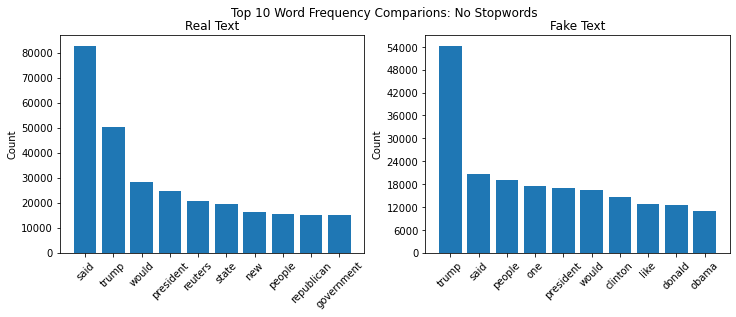

In [188]:
top_10_comparison('text_without_stopwords', "Top 10 Word Frequency Comparions: No Stopwords")

The fake and real distributions have similar words but in a different order.

### Model 2

In [123]:
# Instantiate the vectorizer
tfidf_2 = TfidfVectorizer(
    max_features=10,
    stop_words=stopwords_list
)
# Fit the vectorizer on X_train and transform train and val sets
tfidf_2.fit(X_train)
X_train_vectorized_2 = tfidf_2.transform(X_train)
X_val_vectorized_2 = tfidf_2.transform(X_val)

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized_2, 
                                  columns=tfidf_2.get_feature_names())

,also,clinton,new,one,people,president,said,state,trump,would
0,0.000000,0.000000,0.000000,0.099169,0.000000,0.186825,0.000000,0.000000,0.977375,0.000000
1,0.269183,0.000000,0.000000,0.000000,0.000000,0.729911,0.574426,0.000000,0.254568,0.000000
2,0.000000,0.890351,0.219306,0.000000,0.398973,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.484342,0.499764,0.000000,0.718087,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
32295,0.234127,0.000000,0.000000,0.673973,0.463622,0.000000,0.166539,0.267925,0.000000,0.420096
32296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
32297,0.316555,0.000000,0.344564,0.151876,0.470135,0.000000,0.675514,0.000000,0.000000,0.283999
32298,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [124]:
# Instantiate a MultinomialNB classifier and fit to data
model_2 = MultinomialNB()
model_2.fit(X_train_vectorized_2, y_train)

MultinomialNB()

In [125]:
print_train_val_acc(model_2, 
                    X_train_vectorized_2,
                    X_val_vectorized_2)

train acc:  0.7428792569659443
val acc:  0.7371929824561404


Improvement over baseline model

## Stemming and Tokenization
The data for model three is stemmed and uses a new tokenizer in addition to removing stopwords.

In [131]:
# define stemmer
stemmer = SnowballStemmer(language="english")

# define fucntion to stem and tokenize
def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [stemmer.stem(token) for token in tokens]

In [132]:
# stem the stopwords list 
stemmed_stopwords = [stemmer.stem(word) for word in stopwords_list]

In [133]:
# add stemmed and tokeinzed data column
eda_X_train["stemmed_and_tokenized"] = eda_X_train["text"].apply(stem_and_tokenize)
eda_X_train["stemmed_and_tokenized"] = eda_X_train["stemmed_and_tokenized"].apply(remove_stopwords)

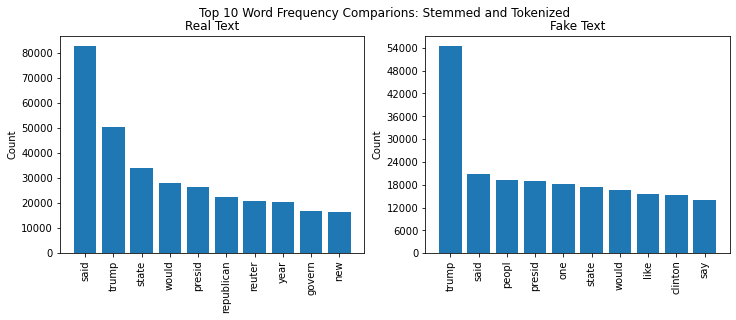

In [134]:
top_10_comparison('stemmed_and_tokenized', "Top 10 Word Frequency Comparions: Stemmed and Tokenized")

### Model 3

In [136]:
# Instantiate the vectorizer with stemming, tokeinzation, and stopword removal
tfidf_3 = TfidfVectorizer(
    max_features=10,
    stop_words=stemmed_stopwords,
    tokenizer=stem_and_tokenize
)

# Fit the vectorizer on X_train text
tfidf_3.fit(X_train)
X_train_vectorized_3 = tfidf_3.transform(X_train)
X_val_vectorized_3 = tfidf_3.transform(X_val)

In [137]:
# Instantiate a MultinomialNB classifier
model_3 = MultinomialNB()
model_3.fit(X_train_vectorized_3, y_train)

MultinomialNB()

In [138]:
print_train_val_acc(model_3, X_train_vectorized_3, X_val_vectorized_3)

train acc:  0.7479876160990712
val acc:  0.7407017543859649


Small improvement over model 2.

## Model 4: Increasing Max Features
Up until this point, we have developed the model only using the top 10 most frequent features. In this model, that is incresased to the top 100 features.

In [139]:
# Instantiate the vectorizer
tfidf_4 = TfidfVectorizer(
    max_features=100,
    stop_words=stemmed_stopwords,
    tokenizer=stem_and_tokenize
)

# Fit the vectorizer on X_train and transform X_train and X_val
tfidf_4.fit(X_train)
X_train_vectorized_4 = tfidf_4.transform(X_train)
X_val_vectorized_4 = tfidf_4.transform(X_val)


# Create a full df of vectorized + engineered features
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized_4, columns=tfidf_4.get_feature_names())

,accord,administr,also,america,american,ask,attack,back,bill,call,...,want,washington,way,week,well,white,work,world,would,year
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.076443,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.101221,0.000000,0.067500
1,0.000000,0.000000,0.158447,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.175576,...,0.000000,0.197487,0.0,0.000000,0.000000,0.417513,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.123864,...,0.000000,0.000000,0.0,0.000000,0.152747,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.222078,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.140629,0.000000,0.000000,0.000000,0.000000,0.000000,0.466122,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.102733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32295,0.066516,0.000000,0.049661,0.074226,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.061469,0.000000,0.0,0.061912,0.135723,0.000000,0.000000,0.072867,0.089108,0.000000
32296,0.000000,0.162727,0.000000,0.000000,0.133253,0.000000,0.000000,0.133706,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.572942,0.000000,0.000000,0.000000,0.000000
32297,0.036887,0.000000,0.055080,0.000000,0.000000,0.037789,0.000000,0.033870,0.0,0.030517,...,0.068176,0.000000,0.0,0.000000,0.000000,0.471692,0.034274,0.000000,0.049415,0.107787
32298,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [140]:
# Instantiate a MultinomialNB classifier
model_4 = MultinomialNB()
model_4.fit(X_train_vectorized_4, y_train)

MultinomialNB()

In [148]:
print_train_val_acc(model_4, X_train_vectorized_4, X_val_vectorized_4)

train acc:  0.8702786377708979
val acc:  0.8666666666666667


Minimal accuracy increase

## Model 5: POS Tag

In [144]:
# define fucntion to convert to POS Tag
def stem_tokenize_tag(document):
    tokens = tokenizer.tokenize(document)
    stem_tokens = [stemmer.stem(token) for token in tokens]
    return pos_tag(stem_tokens)

In [145]:
# Instantiate the vectorizer
tfidf_5 = TfidfVectorizer(
    max_features=100,
    stop_words=stemmed_stopwords,
    tokenizer=stem_tokenize_tag
)

# Fit the vectorizer on X_train and transform X_train and X_val
tfidf_5.fit(X_train)
X_train_vectorized_5 = tfidf_5.transform(X_train)
X_val_vectorized_5 = tfidf_5.transform(X_val)


# Create a full df of vectorized + engineered features
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized_5, columns=tfidf_5.get_feature_names())

,"(about, IN)","(after, IN)","(against, IN)","(all, DT)","(also, RB)","(american, JJ)","(an, DT)","(and, CC)","(are, VBP)","(as, IN)",...,"(what, WP)","(when, WRB)","(which, WDT)","(white, JJ)","(who, WP)","(will, MD)","(with, IN)","(would, MD)","(year, NN)","(you, PRP)"
0,0.062513,0.065097,0.0,0.036265,0.000000,0.000000,0.026602,0.080177,0.083862,0.024800,...,0.070774,0.103809,0.000000,0.000000,0.056046,0.031162,0.187024,0.000000,0.033625,0.000000
1,0.000000,0.103703,0.0,0.115542,0.109491,0.000000,0.000000,0.063863,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.288511,0.000000,0.000000,0.148969,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.080564,0.121408,0.084659,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070800,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.522000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050735,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.344188,0.064836,0.090421,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.090644,0.000000,0.226857,0.000000,0.108765,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32295,0.000000,0.047461,0.0,0.000000,0.025055,0.000000,0.019395,0.248436,0.020381,0.054243,...,0.051600,0.000000,0.023643,0.000000,0.061293,0.045439,0.068178,0.044957,0.000000,0.027925
32296,0.069804,0.072690,0.0,0.000000,0.000000,0.094170,0.000000,0.044764,0.000000,0.000000,...,0.000000,0.077278,0.000000,0.404460,0.000000,0.000000,0.000000,0.000000,0.000000,0.085537
32297,0.053232,0.055432,0.0,0.046321,0.029263,0.000000,0.113262,0.238957,0.047608,0.042235,...,0.045200,0.029466,0.013807,0.250605,0.095450,0.013268,0.119443,0.026254,0.057266,0.130459
32298,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.339186,0.000000,0.000000,0.000000,...,0.000000,0.441205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [146]:
# Instantiate a MultinomialNB classifier
model_5 = MultinomialNB()
model_5.fit(X_train_vectorized_5, y_train)

MultinomialNB()

In [147]:
print_train_val_acc(model_5, X_train_vectorized_5, X_val_vectorized_5)

train acc:  0.8492260061919504
val acc:  0.8480701754385965


Best accuracy thus far

## Model 6: Adding Bigrams

In [196]:
# Instantiate the vectorizer with bigrams added
tfidf_6 = TfidfVectorizer(
    max_features=100,
    ngram_range=(1,2),
    stop_words=stemmed_stopwords,
    tokenizer=stem_and_tokenize
)

# Fit the vectorizer on X_train and transform it
tfidf_6.fit(X_train)
X_train_vectorized_6 = tfidf_6.transform(X_train)
X_val_vectorized_6 = tfidf_6.transform(X_val)


# Create a full df of vectorized + engineered features
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized_5, columns=tfidf_5.get_feature_names())

,"(about, IN)","(after, IN)","(against, IN)","(all, DT)","(also, RB)","(american, JJ)","(an, DT)","(and, CC)","(are, VBP)","(as, IN)",...,"(what, WP)","(when, WRB)","(which, WDT)","(white, JJ)","(who, WP)","(will, MD)","(with, IN)","(would, MD)","(year, NN)","(you, PRP)"
0,0.062513,0.065097,0.0,0.036265,0.000000,0.000000,0.026602,0.080177,0.083862,0.024800,...,0.070774,0.103809,0.000000,0.000000,0.056046,0.031162,0.187024,0.000000,0.033625,0.000000
1,0.000000,0.103703,0.0,0.115542,0.109491,0.000000,0.000000,0.063863,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.288511,0.000000,0.000000,0.148969,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.080564,0.121408,0.084659,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070800,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.522000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050735,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.344188,0.064836,0.090421,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.090644,0.000000,0.226857,0.000000,0.108765,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32295,0.000000,0.047461,0.0,0.000000,0.025055,0.000000,0.019395,0.248436,0.020381,0.054243,...,0.051600,0.000000,0.023643,0.000000,0.061293,0.045439,0.068178,0.044957,0.000000,0.027925
32296,0.069804,0.072690,0.0,0.000000,0.000000,0.094170,0.000000,0.044764,0.000000,0.000000,...,0.000000,0.077278,0.000000,0.404460,0.000000,0.000000,0.000000,0.000000,0.000000,0.085537
32297,0.053232,0.055432,0.0,0.046321,0.029263,0.000000,0.113262,0.238957,0.047608,0.042235,...,0.045200,0.029466,0.013807,0.250605,0.095450,0.013268,0.119443,0.026254,0.057266,0.130459
32298,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.339186,0.000000,0.000000,0.000000,...,0.000000,0.441205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [197]:
# Instantiate a MultinomialNB classifier
model_6 = MultinomialNB()
model_6.fit(X_train_vectorized_6, y_train)

MultinomialNB()

In [199]:
print_train_val_acc(model_6, X_train_vectorized_6, X_val_vectorized_6)

train acc:  0.8664705882352941
val acc:  0.8617543859649123


## Vectorization Strategy
Thus far, we have vectorized the data using on the Tdidf vectorizer. Here, we try some different options.

### Count Vectorizer

In [201]:
# Instantiate the vectorizer
count_vec_7 = CountVectorizer(
    max_features=100,
    stop_words=stemmed_stopwords
)

# Fit the vectorizer on X_train["text"] and transform it
count_vec_7.fit(X_train)
X_train_vectorized_7 = count_vec_7.transform(X_train)
X_val_vectorized_7 = count_vec_7.transform(X_val)


# Create a full df of vectorized + engineered features
#pd.DataFrame.sparse.from_spmatrix(X_train_vectorized_6, columns=count_vec_6.get_feature_names())

In [203]:
# Instantiate a MultinomialNB classifier
model_7 = MultinomialNB()
model_7.fit(X_train_vectorized_7, y_train)

MultinomialNB()

In [204]:
print_train_val_acc(model_7, X_train_vectorized_7, X_val_vectorized_7)

train acc:  0.8806501547987616
val acc:  0.882280701754386


Tfidf vectorized produced better results

## Classifiers

### Support Vector Machine

In [293]:
svm = SVC(kernel='linear')
svm.fit(X_train_vectorized_7, y_train)

SVC(kernel='linear')

In [295]:
print_train_val_acc(svm, X_train_vectorized_7, X_val_vectorized_7)

train acc:  0.948266253869969
val acc:  0.9443859649122807


### Logistic Regression

In [205]:
lg = LogisticRegression()
lg.fit(X_train_vectorized_7, y_train)

LogisticRegression()

In [206]:
print_train_val_acc(lg, X_train_vectorized_7, X_val_vectorized_7)

train acc:  0.9513003095975232
val acc:  0.9524561403508772


### Random Forest

In [211]:
rf = RandomForestClassifier()
rf.fit(X_train_vectorized_7, y_train)

RandomForestClassifier()

In [212]:
print_train_val_acc(rf, X_train_vectorized_7, X_val_vectorized_7)

train acc:  0.9996284829721362
val acc:  0.9508771929824561


### XGBoost

In [207]:
#instantiate a baseline XGBoost Classifier
xgb = XGBClassifier()
xgb.fit(X_train_vectorized_7, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [208]:
print_train_val_acc(xgb, X_train_vectorized_7, X_val_vectorized_7)

train acc:  0.9902167182662539
val acc:  0.9535087719298245


In [300]:
#define parameter grid for search
xgb_param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [2,4,6],
    'min_child_weight': [1, 2],
    'subsample': [0.2, 0.5],
    'n_estimators': [100],
}

#insantiate and fit search object
grid_xgb = GridSearchCV(xgb,
                        xgb_param_grid,
                        scoring='accuracy',
                        cv=3, n_jobs=1,
                        refit='accuracy',
                        return_train_score=True)

grid_xgb.fit(X_train_vectorized_4, y_train)

#print best parameters
best_parameters = grid_xgb.best_params_
print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 2
n_estimators: 100
subsample: 0.5


In [209]:
#instantiate a baseline XGBoost Classifier
xgb2 = XGBClassifier(learning_rate=0.1,
                   max_depth=6,
                   min_child_weight=2,
                   n_estimators=100,
                   subsample=0.5)
xgb2.fit(X_train_vectorized_7, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [210]:
print_train_val_acc(xgb2, X_train_vectorized_7, X_val_vectorized_7)

train acc:  0.9734984520123839
val acc:  0.9545614035087719


## Final Evaluation

In [151]:
final_model = xgb2
X_test_vec_final = tfidf_4.transform(X_test)

In [152]:
test_preds= final_model.predict(X_test_vec_final)

print("Final Model Test Accuracy: ", accuracy_score(test_preds, y_test))

Final Model Test Accuracy:  0.955860423501342


In [191]:
cm = confusion_matrix(y_test, test_preds)

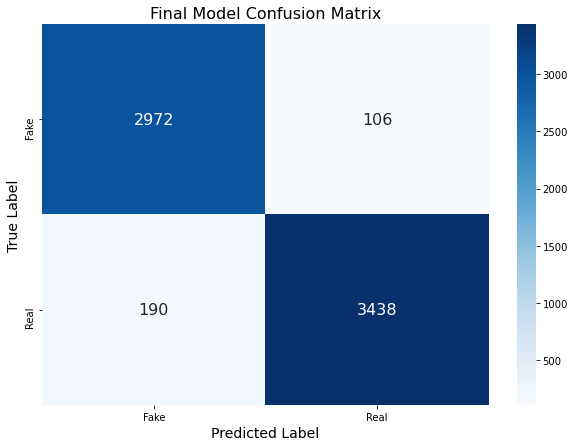

In [195]:
# plot confusion matrix of final model
df_cm = pd.DataFrame(cm, index = ['Fake', 'Real'],
                  columns = ['Fake', 'Real'])
fig, ax = plt.subplots(figsize=(10,7))
ax = sn.heatmap(df_cm, annot=True, annot_kws={'fontsize': 16}, cmap='Blues', fmt='g');
ax.set_xlabel('Predicted Label', fontsize=14);
ax.set_ylabel('True Label', fontsize=14);
plt.title('Final Model Confusion Matrix', fontsize=16);

## Conclusion

## Next Steps